In [72]:
import numpy as np
from numpy.linalg import norm
from legacy import legacy_adapter as adapter
from legacy import main as legacy
import template as example
from data import funcs
import regression as reg
from proc_observe import ProcInfo

In [73]:
def lbfgs(grad, generations, points, eps, max_iter):
    if len(points) < generations + 1:
        raise AttributeError("The length of s or y is too small")
    
    E = np.eye(len(points[0]))
    point = points[-1]
    
    s = [points[i] - points[i - 1] for i in range(1, generations + 1)] # [row(n)]
    y = [grad(points[i]) - grad(points[i - 1]) for i in range(1, generations + 1)] # [row(n)]
    rho = [1 / y[i] @ s[i] for i in range(generations)] # [scalar]
    
    print("s=", s)
    print("y=", y)
    print("rho=", rho)
    for ki in range(0, max_iter):
        q = grad(point)
        g = q
        
        if norm(q) < eps:
            break
        
        alpha = np.zeros(generations)
        for it in range(0, generations):
            i = generations - (it + 1)
            alpha[i] = rho[i] * (s[i] @ q)
            q -= alpha[i] * y[i]
        
        gamma = (s[-1] @ y[-1]) / (y[-1] @ y[-1])
        hess = gamma * E
        
        z = hess @ q
        
        betta = np.zeros(generations)
        for i in range(0, generations):
            betta[i] = rho[i] * (y[i] @ z)
            z += s[i] * (alpha[i] - betta[i])
        z = -z
        # z = -H_k @ g_k
        point += z
        
        if y[-1] @ s[-1] < eps:
            continue
        print(y[-1] @ s[-1])
            
        s = s[1:]
        s.append(z)

        y = y[1:]
        y.append(grad(point) - g)

        rho = rho[1:]
        rho.append(1 / y[-1] @ s[-1])

        print()
        print("s=", s)
        print("y=", y)
        print("rho=", rho)
        
    return point

In [74]:
def f(point):
    x, y = point[0], point[1]
    return x ** 2 - x * y + y ** 2 + 9 * x - 6 * y + 20

def grad(point):
    x, y = point[0], point[1]
    return np.array([[2 * x - y + 9], [-x + 2 * y - 6]])

Для нахождения первых m s и y хотелось бы использовать какие-то алгоритмы, которые могут хоть как-то приближают нас к минимуму, для этого можно
1. Воспользоваться многочисленными вариантами градиентного спуска
2. Запустить BFGS, но это будет не выгодно, т.к. мы изначально хотим избавиться от хранения большой матрицы, то есть мы не решаем проблему, хотя в дальнейшем нам не нужно будет каждый раз высчитывать гигантскую матрицу
3. Powell dog leg -- звучит как что-то не то, что хотелось бы использовать
4. G-N не та задача

То есть самым лучшим вариантом остаётся градиентный спуск и его вариации

In [75]:
# def create_regression_test(func, jacobian, regression, grad, legacy_linear_function=None):
#     def run(x: np.ndarray,
#             y: np.ndarray,
#             start: np.ndarray,
#             generations: int,
#             eps: float,
#             learning_rate,
#             batch_size,
#             max_iter: int):
#         r = regression(func, x, y)
#         g = grad(x, jacobian, r)
#         
#         if legacy_linear_function is not None:
#             _, proc_info = (adapter.to_normal_function(legacy_linear_function, g)
#                             (x, y, start, eps, learning_rate, batch_size, generations))
#             points = proc_info.points
#         else:
#             t = 1
#             points = [np.array([start[j] + float(i) * t
#                                 for j in range(len(start))])
#                       for i in range(generations + 1)]
#         print(points)
#         return lbfgs(grad(x, jacobian, r), generations, points, eps, max_iter)
# 
#     return run

In [76]:
def create_regression_test(func, jacobian, regression, grad, legacy_function=None):
    def run(x, y, start, generations, eps, learning_rate, batch_size, max_iter):
        r = regression(func, x, y)
        g = grad(x, jacobian, r)
        
        points = [np.array([start[j] + i * 10 for j in range(len(start))])
                  for i in range(generations + 1)]
        return lbfgs(g, generations, points, eps, max_iter)
    return run

s= [array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.])]
y= [array([5.31190855e+05, 4.62335482e+06, 4.14431872e+07, 3.79319377e+08,
       3.52613919e+09]), array([5.31190855e+05, 4.62335482e+06, 4.14431872e+07, 3.79319377e+08,
       3.52613919e+09]), array([5.31190855e+05, 4.62335482e+06, 4.14431872e+07, 3.79319377e+08,
       3.52613919e+09]), array([5.31190855e+05, 4.62335482e+06, 4.14431872e+07, 3.79319377e+08,
       3.52613919e+09]), array([5.31190855e+05, 4.62335482e+06, 4.14431872e+07, 3.79319377e+08,
       3.52613919e+09])]
rho= [2.125905000099017e-05, 2.125905000099017e-05, 2.1259050000990183e-05, 2.1259050000990166e-05, 2.125905000099016e-05]
39520562998.95553

s= [array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([10., 10., 10., 10., 10.]), array([-8.76266527e+60, -8.76266527e+60, -8.76266527e+60, -8

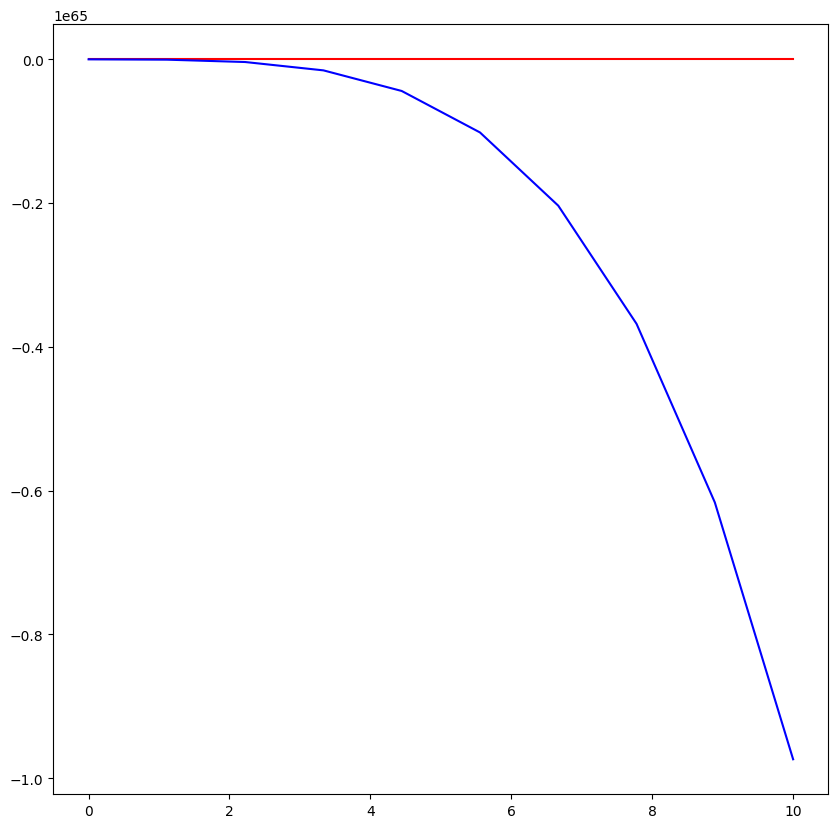

In [77]:
start = 0
end = 10
steps = 10

test_x, test_y = example.generate_test(np.sin, start, end, steps)
x0 = np.array([1., 0., 0., 0., 0.])
func, jac = funcs["pol"]
test = create_regression_test(func, jac, reg.regression, reg.grad)

betta = test(test_x, test_y, x0, 5, 1e-4, 0.01, 1, 1)

X = np.linspace(start, end, steps)
Y = func(X)(betta)

example.show(test_x, test_y, X, Y)

In [78]:
betta

array([-8.76266527e+60, -8.76266527e+60, -8.76266527e+60, -8.76266527e+60,
       -8.76266527e+60])